In [8]:
import pickle 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline


with open('lgbm-model-ilapak3-v1.0.0.pkl', 'rb') as f:
    model = pickle.load(f)

df = pd.read_csv('data/ilapak3/test.csv')
df['times'] = pd.to_datetime(df['times'], format='%Y-%m-%d %H:%M:%S')

# utils
def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    X = data.copy()
    # Times
    X['day'] = X['times'].dt.day
    X['hour'] = X['times'].dt.hour
    X['minute'] = X['times'].dt.minute
    # Diff
    X['diff_sealing_vertical'] = X['Suhu Sealing Vertical Atas (oC)'] - X['Suhu Sealing Vertikal Bawah (oC)']
    X['diff_sealing_horizontal'] = X['Suhu Sealing Horizontal Depan/Kanan (oC)'] - X['Suhu Sealing Horizontal Belakang/Kiri (oC )']
    X['diff_output'] = X['Counter Output (pack)'] - X['Counter Reject (pack)']
    X['diff_counter_output'] = X['Counter Output (pack)'].diff().fillna(0)
    X['diff_counter_reject'] = X['Counter Reject (pack)'].diff().fillna(0)
    return X

def inference(data: pd.DataFrame, estimator: Pipeline, classes: dict = {0: 'Normal', 1: 'Warning', 2: 'Leak'}):
    X = preprocess(data)
    pred = classes[estimator.predict(X)[0]]
    probs = estimator.predict_proba(X)[0]

    return pred, probs


In [9]:
df.head()

,times,Shift,Status,Suhu Sealing Vertikal Bawah (oC),Suhu Sealing Vertical Atas (oC),Suhu Sealing Horizontal Depan/Kanan (oC),Suhu Sealing Horizontal Belakang/Kiri (oC ),Counter Output (pack),Counter Reject (pack),Speed(rpm),...,Quality(%),OEE(%),Jaws Position,Doser Drive Enable,Sealing Enable,Machine Alarm,Downtime_sec,Output Time_sec,Total Time_sec,Condition
0,2025-06-05 05:59:46,3,3,207.9,209.8,201.3,202.1,0,0,0.0,...,0.0,0.0,0,0,0,0,687.0,0.0,688.0,0
1,2025-06-05 06:00:46,3,3,208.8,210.7,202.0,202.6,0,0,0.0,...,0.0,0.0,0,0,0,0,747.0,0.0,747.0,0
2,2025-06-05 06:01:50,3,3,209.6,211.4,202.5,202.9,0,0,0.0,...,0.0,0.0,0,0,0,0,806.0,0.0,806.0,0
3,2025-06-05 06:02:48,3,3,210.3,211.9,202.8,203.3,0,0,0.0,...,0.0,0.0,0,0,0,0,864.0,0.0,864.0,0
4,2025-06-05 06:03:46,3,3,211.1,212.5,203.1,203.6,0,0,0.0,...,0.0,0.0,0,0,0,0,924.0,0.0,925.0,0


In [10]:
X = df.drop(['Condition'], axis=1)
y = df['Condition']

X = preprocess(X)

y_pred = model.predict(X)
y_proba = model.predict_proba(X)

labels = np.array([0, 1, 2])
class_names = ["Normal", "Warning", "Leak"]

/home/gemitry/Projects/lstm-ae-anomaly-detection/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gemitry/Projects/lstm-ae-anomaly-detection/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# Evaluation

In [ ]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
)
from sklearn.preprocessing import label_binarize

In [12]:
print(classification_report(y, y_pred, target_names=class_names, digits=2))

              precision    recall  f1-score   support

      Normal       0.83      0.99      0.90       671
     Warning       0.67      0.17      0.27       168
        Leak       0.62      0.71      0.67        14

    accuracy                           0.82       853
   macro avg       0.71      0.62      0.61       853
weighted avg       0.80      0.82      0.77       853



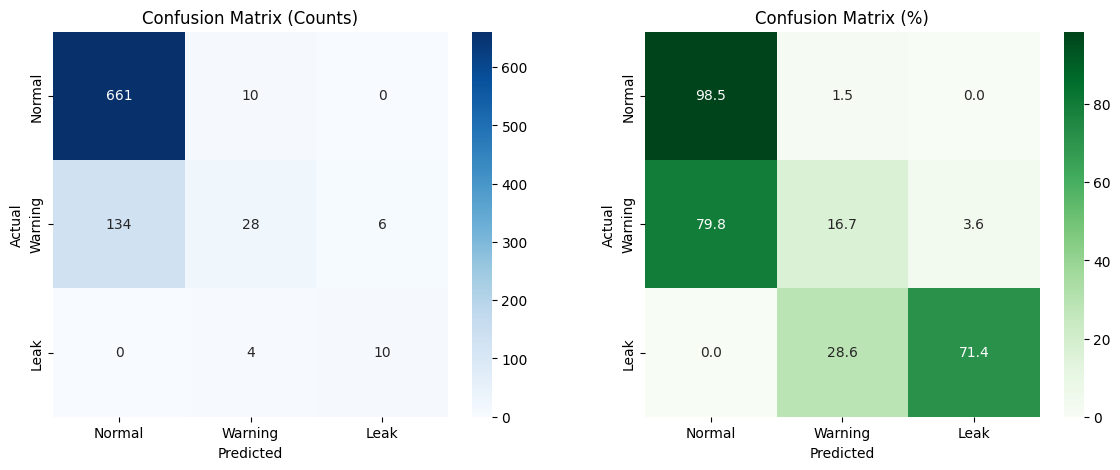

In [13]:
cm = confusion_matrix(y, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axs[0])
axs[0].set_title('Confusion Matrix (Counts)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

sns.heatmap(cm_percent * 100, annot=True, fmt='.1f', cmap='Greens', xticklabels=class_names, yticklabels=class_names, ax=axs[1])
axs[1].set_title('Confusion Matrix (%)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

plt.show()